In [3]:
#libraries
import numpy as np
import pandas as pd
from time import time

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [7]:
df = pd.read_csv("./data/cyberbullying_tweets.csv")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


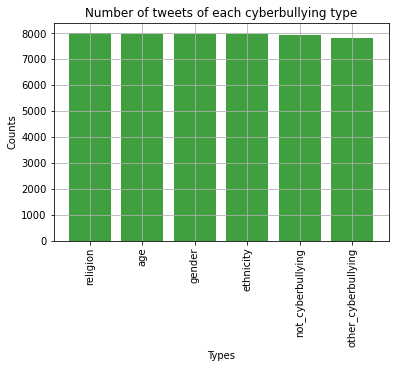

In [32]:
index = df.cyberbullying_type.value_counts().index.tolist()
values = df.cyberbullying_type.value_counts().values.tolist()

plt.bar(index, values, facecolor='g', alpha=0.75)

plt.xlabel('Types')
plt.ylabel('Counts')
plt.title('Number of tweets of each cyberbullying type')
# Rotation of the bar names
plt.xticks(index, rotation=90)
# plt.subplot_adjust(bottom=0.01, top=0.99)

plt.grid(True)
plt.show()

In [61]:
X = df.iloc[::,0].to_numpy()
X = [''.join(item.lower() for item in x if item.isalpha() or item == " ") for x in X]
# X = [x.split(" ") for x in X]
X
#X = [item for sublist in X for item in sublist]

['in other words katandandre your food was crapilicious mkr',
 'why is aussietv so white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc',
 'xochitlsuckkks a classy whore or more red velvet cupcakes',
 'jasongio meh p  thanks for the heads up but not too concerned about another angry dude on twitter',
 'rudhoeenglish this is an isis account pretending to be a kurdish account  like islam it is all lies',
 'rajaaab quickieleaks yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence',
 'itu sekolah ya bukan tempat bully ga jauh kaya neraka',
 'karma i hope it bites kat on the butt she is just nasty mkr',
 'stockputout everything but mostly my priest',
 'rebecca black drops out of school due to bullying',
 'jordisdead httptcousqinywgn',
 'the bully flushes on kd httptwitvidcomatnp',
 'ughhhh mkr',
 'rt kurdsnews turkish state has killed  children in last  years httptcojlvkeepws  news  googleçeviricitopluluğukür

In [67]:
# !pip install langdetect

from langdetect import detect, DetectorFactory

# Language detection algorithm is non-deterministic, 
# which means that if you try to run it on a text which is either too short or too ambiguous,
# you might get different results everytime you run it.
DetectorFactory.seed = 0

# Detecting language and errors 
cnt = 0
for row in X:
    try : df.loc[cnt, 'language'] = detect(row)
    except Exception as exception:
        print("Error in language detection : tweet n°", cnt, "-->", df.tweet_text[cnt])
    cnt += 1

Error in language detection : tweet n° 4011  --> ♪♥♪
Error in language detection : tweet n° 8695  --> 😂😂😂😂😂
Error in language detection : tweet n° 14458  --> 👧👧👧👧 …
Error in language detection : tweet n° 14691  --> ♫♪
Error in language detection : tweet n° 24110  --> ?????????
Error in language detection : tweet n° 24529  --> 5/16/15
Error in language detection : tweet n° 25032  --> 01:15:19:00
Error in language detection : tweet n° 25846  --> 5/14/15
Error in language detection : tweet n° 26069  --> 💃🍦🐙😇🌸🌟
Error in language detection : tweet n° 26461  --> 5/11/15
Error in language detection : tweet n° 27618  --> 5/17/15
Error in language detection : tweet n° 27928  --> 5/13/15
Error in language detection : tweet n° 28228  --> &#128533;
Error in language detection : tweet n° 28468  --> :-)
Error in language detection : tweet n° 28855  --> 💩
Error in language detection : tweet n° 31214  --> 5/12/15
Error in language detection : tweet n° 31286  --> .
Error in language detection : tweet n

In [70]:
df.loc[31676]

tweet_text                        5/10/15
cyberbullying_type    other_cyberbullying
language                              NaN
Name: 31676, dtype: object

In [75]:
df.language.value_counts(normalize=True)

en    0.936129
pt    0.006712
da    0.004782
af    0.004782
cy    0.004174
id    0.003860
so    0.003755
no    0.003713
es    0.003000
tl    0.002895
it    0.002811
sv    0.002706
et    0.002538
nl    0.002496
fr    0.002119
fi    0.002077
ca    0.001720
sw    0.001070
hr    0.001028
de    0.001028
sl    0.000986
sq    0.000986
ro    0.000860
tr    0.000755
pl    0.000608
hu    0.000608
cs    0.000566
sk    0.000420
vi    0.000336
lt    0.000294
ja    0.000105
lv    0.000084
Name: language, dtype: float64

In [72]:
df[df.language == 'ja']

,tweet_text,cyberbullying_type,language
3237,なぁなぁパンツちょーだいパンツ。パンツくれよ！パンツくれよォ！パンツくれよお前！パンツくらい...,not_cyberbullying,ja
6145,ラストのパンツ… ラスパン発見！ラスパンじっくり見よ。ワーオｗｗｗ （BULLY・13）,not_cyberbullying,ja
7304,【自動post】BULLY（いじめ）とSUICIDE（自殺）で、BULLYCIDE（いじめ自...,not_cyberbullying,ja
27996,¯\_(ツ)_/¯,other_cyberbullying,ja
32211,"July 28 HAWAII School extend, Stabbing, Cyber ...",age,ja


In [74]:
df.tweet_text.loc[32211]

'July 28 HAWAII School extend, Stabbing, Cyber Bully, Open Tours, Boxin... https://youtu.be/XpJ4S0njciA @YouTubeより #ハワイニュース #ハワイニュースナウ #ハワイロールニュース #ハワイリアルニュース'

In [62]:
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_df=0.7, min_df=4)
# max_df : removes term with DF higher than the 70% of the documents
# min_df : terms must have DF>=4 to be considered

start = time()
X_tfidf = vectorizer.fit_transform(X)
vec_time = time() - start

print("Extracting features from X using TfidfVectorizer")
print("n_samples: %d, n_features: %d" % X_tfidf.shape)
print("TfidfVectorizer takes %fs" % vec_time)

vectorizer.get_feature_names_out()

Extracting features from X using TfidfVectorizer
n_samples: 47692, n_features: 27363
TfidfVectorizer takes 1.644305s


array(['aa', 'aaa', 'aaaand', ..., 'ððââï', 'ððð', 'ðððð'], dtype=object)

In [63]:
def top_tfidf_feats(row, features, top_n=25):
    '''Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, max_tfidf=0.3, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    D[D > max_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, max_tfidf=0.3, top_n=25):
    '''Return a list of dfs, where each df holds top_n features and their mean tfidf value
       calculated across documents with the same class label.'''
    dfs=[]
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, min_tfidf=min_tfidf, max_tfidf=max_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
top_tfidf_feats()

In [33]:
types = {'age':0,
         'ethnicity':1,
         'gender':2,
         'not_cyberbullying':3,
         'other_cyberbullying':4,
         'religion':5}

In [34]:
Y = df.iloc[::,1].to_numpy()
Y = [types[y] for y in Y]
Y = np.reshape(Y, (len(Y),1))
Y

array([[3],
       [3],
       [3],
       ...,
       [1],
       [1],
       [1]])

In [40]:
import gensim
from gensim.models import Word2Vec
print(gensim.__version__)

4.1.2


In [41]:
model_w2v = Word2Vec(
            X,
            vector_size=50, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34) 

model_w2v.train(X, total_examples = len(X), epochs=20)

(17149929, 22638920)

In [42]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
            
    if count != 0:
        vec /= count
        
    return vec

In [43]:
wordvec_arrays = np.zeros((len(X), 50)) 

for i in range(len(X)):
    wordvec_arrays[i,:] = word_vector(X[i], 50)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(47692, 50)

In [44]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.190234,-0.001822,0.477799,0.072039,-0.541166,0.105484,-0.234871,0.090210,0.649601,-0.145839,...,-0.460403,-0.077160,0.833268,-0.471736,0.545666,-0.137286,0.053156,-0.291512,-0.183101,0.002810
1,0.181969,0.067102,0.326872,0.058221,-0.321054,0.224921,-0.095294,0.004834,0.576324,0.059919,...,-0.352825,-0.170523,0.521124,-0.250114,0.231693,-0.138593,0.049427,-0.242536,-0.077007,-0.086140
2,0.019835,-0.028382,0.445418,0.071778,-0.029047,0.284140,-0.175984,-0.016353,0.493089,0.055116,...,-0.245383,-0.315484,0.320529,0.067019,0.692271,-0.241580,-0.021230,-0.176546,0.019765,0.074969
3,0.034483,-0.120694,0.268664,0.387421,-0.321113,0.352193,-0.309989,-0.062678,0.477904,0.049680,...,-0.436948,0.015575,0.381826,0.058891,0.193958,-0.159697,0.283076,-0.273258,-0.235225,-0.095040
4,0.299948,-0.109814,0.293155,0.342120,-0.472618,0.436882,-0.219825,-0.073014,0.542196,0.111648,...,-0.357605,-0.239689,0.391796,-0.140259,0.119676,-0.208344,0.152116,-0.396879,-0.116867,-0.096979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47687,0.042532,-0.263092,0.153243,0.256546,-0.485918,0.303651,-0.374119,0.097810,0.544097,-0.049239,...,-0.366355,-0.163050,0.447419,-0.240233,0.436101,-0.249686,0.284193,-0.210581,-0.018950,0.022245
47688,0.097085,-0.300832,0.278792,0.189940,-0.365896,0.323768,-0.398509,-0.001643,0.572675,0.026881,...,-0.252198,-0.217035,0.426564,-0.101931,0.349490,-0.440050,0.279022,-0.350701,0.049914,-0.079702
47689,-0.045917,-0.000585,0.174998,0.141452,-0.037473,0.158622,-0.013022,0.177573,0.531250,-0.058799,...,-0.435150,-0.070652,0.436059,-0.057799,0.507160,-0.148344,0.355724,-0.518279,-0.034705,0.159057
47690,0.151521,-0.008375,0.291205,0.353568,0.049613,0.032441,0.194611,0.243406,0.701627,-0.080747,...,-0.549798,-0.026912,0.274156,-0.055244,0.375584,0.122651,0.580923,-0.470664,-0.002487,0.284670


In [45]:
class Tree():
    def __init__(self, max_depth, min_samples_split=2, min_samples_leaf=1, splitting=10):
        """Tree Descision Classifier.

        Args:
            max_depth (int): The maximum depth of the tree.
            
            min_samples_split (int): The minimum number of samples
                required to split an internal node.
                
            min_samples_leaf (int): The minimum number of samples
                required to be at a leaf node
        """
        assert max_depth >= 1, "max_depth must be greater or equal than 1"
        assert min_samples_split >= 2, "min_samples_split must be greater or equal than 2"
        assert min_samples_leaf >= 1, "min_samples_leaf must be greater or equal than 1"
        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.splitting = splitting
        self.nodes = {"root": {}}
        
    def gini_index(self, sub, m):
        n = len(sub)
        proportions = sum([((sub[:,-1] == x).sum()/n)**2 for x in np.unique(sub[:,-1])])
        return (1-proportions) * (n/m)
        
        
    def get_split(self, X, depth, node):
        
        m = len(X)
        
        if depth != 0 and m >= self.min_samples_split:
            
            best_split = None
            best_feature = None
            best_value = float("inf")
            
            for feature in range(len(X[0]) - 1):
                if self.splitting is None:
                    uniques = np.unique(X[:,feature])
                else:
                    all_sorted = sorted(X[:,feature])
                    batch = len(all_sorted) // self.splitting
                    uniques = [all_sorted[i*batch] for i in range(self.splitting)]
                for split in uniques:
                    A, B = X[X[:,feature] <= split], X[X[:,feature] > split]
                    if len(A) >= self.min_samples_leaf and len(B) >= self.min_samples_leaf:
                        value = self.gini_index(A, m) + self.gini_index(B, m)
                        if value < best_value:
                            best_value = value
                            best_feature = feature
                            best_split = split
            
            if best_feature is not None:
                A, B = X[X[:,best_feature] <= best_split], X[X[:,best_feature] > best_split]
                node["feature"] = best_feature
                node["split"] = best_split
                node["A"] = {}
                node["B"] = {}
                node["class_A"] = np.unique(A[:,-1])[np.argmax([(A[:,-1] == x).sum() for x in np.unique(A[:,-1])])]
                node["class_B"] = np.unique(B[:,-1])[np.argmax([(B[:,-1] == x).sum() for x in np.unique(B[:,-1])])]
                self.get_split(A, depth-1, node["A"])
                self.get_split(B, depth-1, node["B"])
                
    
    def fit(self, X, y):
        X = np.append(X,y, axis=1)
        self.get_split(X, self.max_depth, self.nodes["root"])
        
    def predict(self, X):
        node = self.nodes["root"]
        while True:
            if X[node["feature"]] <= node["split"]:
                if not node["A"]:
                    return node["class_A"]
                else:
                    node = node["A"]
            else:
                if not node["B"]:
                    return node["class_B"]
                else:
                    node = node["B"]
    
    def score(self, X, Y):
        count = 0
        for x, y in zip(X,Y):
            if self.predict(x) == y: count += 1
        return count/len(X)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, Y, test_size=0.30, random_state=0)
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

clf = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)
clf.fit(X_train, y_train)
print("sk-learn model score: ", clf.score(X_test, y_test))

model = Tree(max_depth=10, min_samples_split = 6, min_samples_leaf= 1, splitting=10)
model.fit(X_train, y_train)
print("Homemade model score: ", model.score(X_test, y_test))

sk-learn model score:  0.6625663964215823
Homemade model score:  0.6676684372379088


In [47]:
class RandomForest():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        
    def fit(self, X, y):
        self.all_trees = []
        sub_size = round(len(X)*(2/3))
        for i in range(self.n_estimators):
            id = np.random.randint(0,len(X),sub_size)
            subX = np.array(X)[id]
            suby = y[id.astype(int)]
            t = Tree(10)
            t.fit(subX, suby)
            self.all_trees.append(t)
            
    def predict(self, X):
        predictions = []
        for t in self.all_trees:
            predictions.append(t.predict(X))
        return max(set(predictions), key=predictions.count)

    def score(self, X, Y):
        count = 0
        for x, y in zip(X,Y):
            if self.predict(x) == y: count += 1
        return count/len(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, Y, test_size=0.30, random_state=0)
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
print("sk-learn model score: ", clf.score(X_test, y_test))

model = RandomForest(10)
model.fit(X_train, y_train)
print("Homemade model score: ", model.score(X_test, y_test))

<ipython-input-48-99ea5ff2ad2a>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


sk-learn model score:  0.7185490634610009
Homemade model score:  0.7269359798714006
